In [20]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score, ConfusionMatrixDisplay
)

# Untuk mengatasi class imbalance
from imblearn.over_sampling import SMOTE

import joblib

# Pengaturan tampilan plot
%matplotlib inline
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8,5)

# Membuat folder artifacts jika belum ada
os.makedirs('artifacts', exist_ok=True)

print("Library siap. Versi pandas:", pd.__version__)


Library siap. Versi pandas: 2.3.0


In [21]:
# Memuat dataset
file_path = r"E:\Tugas Kuliah\Machine Learning\Tugas 3\UCI_Credit_Card.csv"
df = pd.read_csv(file_path)

# Tampilkan beberapa baris pertama dan dimensi dataset
print("Ukuran dataset:", df.shape)
display(df.head())


Ukuran dataset: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [22]:
print("Informasi singkat (info):")
display(df.info())

print("\nRingkasan statistik (describe) untuk kolom numerik:")
display(df.describe().T)

Informasi singkat (info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_

None


Ringkasan statistik (describe) untuk kolom numerik:


,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


In [24]:
target_col = 'default.payment.next.month'   # nama kolom target pada dataset ini

# Tampilkan kolom-kolom
print("Kolom pada dataset:\n", df.columns.tolist())

# Periksa distribusi target
print("\nDistribusi target:")
display(df[target_col].value_counts())

Kolom pada dataset:
 ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month']

Distribusi target:


default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64

In [25]:
# Preprocessing awal: nama kolom, mapping jika perlu, dan encoding sederhana
df_clean = df.copy()

# Beberapa dataset punya kolom 'ID' — jika ada, kita bisa drop (tidak dipakai sebagai fitur)
if 'ID' in df_clean.columns:
    df_clean = df_clean.drop(columns=['ID'])

# Ubah kolom kategorikal yang numeric menjadi tipe kategori (untuk kejelasan)
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE']
for c in cat_cols:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].astype('category')

# Contoh: pada beberapa dataset EDUCATION bernilai 0 atau >4, bisa digabungkan jadi 'Other'
if 'EDUCATION' in df_clean.columns:
    df_clean['EDUCATION'] = df_clean['EDUCATION'].replace({0:4, 5:4, 6:4})  

# Tampilkan perubahan awal
display(df_clean.head())
print("\nTipe data setelah pembersihan:")
display(df_clean.dtypes)


C:\Users\USER\AppData\Local\Temp\ipykernel_17076\265522537.py:16: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_clean['EDUCATION'] = df_clean['EDUCATION'].replace({0:4, 5:4, 6:4})


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0



Tipe data setelah pembersihan:


LIMIT_BAL                      float64
SEX                           category
EDUCATION                     category
MARRIAGE                      category
AGE                              int64
PAY_0                            int64
PAY_2                            int64
PAY_3                            int64
PAY_4                            int64
PAY_5                            int64
PAY_6                            int64
BILL_AMT1                      float64
BILL_AMT2                      float64
BILL_AMT3                      float64
BILL_AMT4                      float64
BILL_AMT5                      float64
BILL_AMT6                      float64
PAY_AMT1                       float64
PAY_AMT2                       float64
PAY_AMT3                       float64
PAY_AMT4                       float64
PAY_AMT5                       float64
PAY_AMT6                       float64
default.payment.next.month       int64
dtype: object

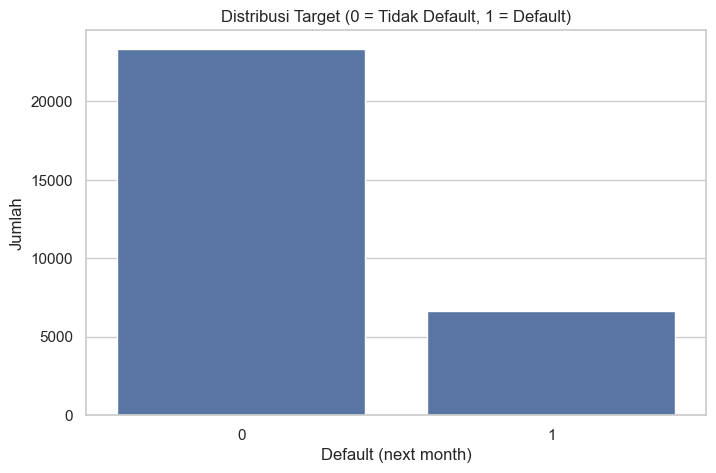

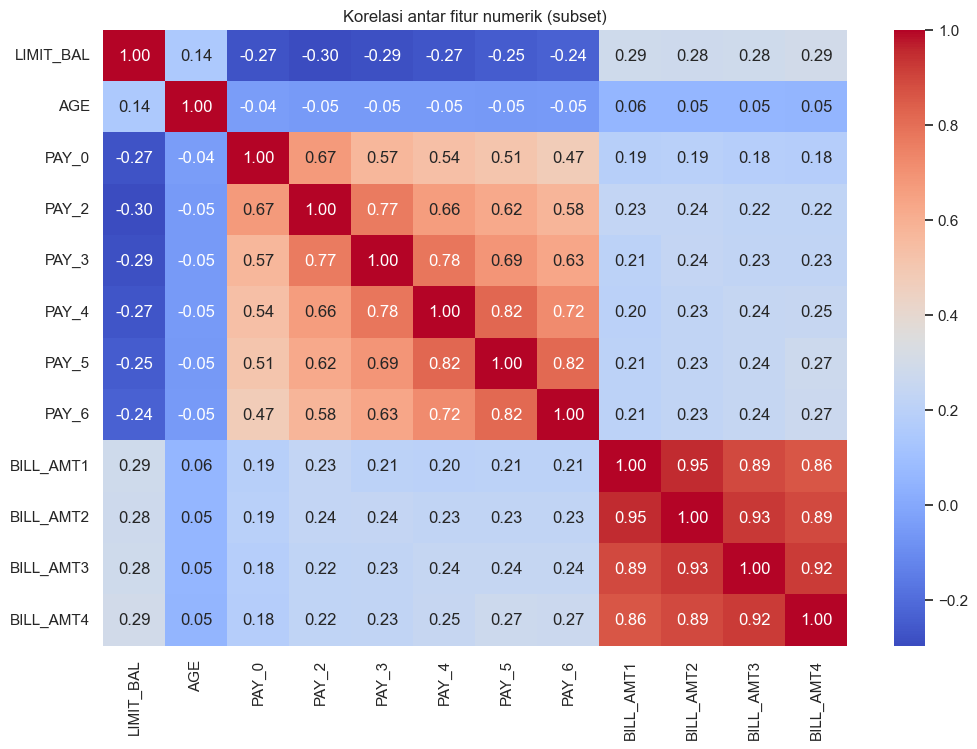

In [26]:
# Visualisasi distribusi target (churn/default)
plt.figure()
sns.countplot(x=target_col, data=df_clean)
plt.title('Distribusi Target (0 = Tidak Default, 1 = Default)')
plt.xlabel('Default (next month)')
plt.ylabel('Jumlah')
plt.show()

# Tampilkan korelasi antar fitur numerik (subset agar cepat)
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
# Batasi kolom untuk korelasi agar plot tidak terlalu padat
sample_num_cols = num_cols[:12] if len(num_cols) > 12 else num_cols
plt.figure(figsize=(12,8))
sns.heatmap(df_clean[sample_num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Korelasi antar fitur numerik (subset)')
plt.show()


In [27]:
df_model = df_clean.copy()

# Pastikan kolom target ada
if target_col not in df_model.columns:
    raise ValueError(f"Kolom target '{target_col}' tidak ditemukan.")

# Pisahkan fitur dan target
X = df_model.drop(columns=[target_col])
y = df_model[target_col]

# One-hot-encode semua kolom kategori
cat_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()
if cat_cols:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

print("Bentuk fitur setelah encoding:", X.shape)
display(X.head())


Bentuk fitur setelah encoding: (30000, 27)


,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_2,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,20000.0,24,2,2,-1,-1,-2,-2,3913.0,3102.0,...,0.0,0.0,0.0,True,True,False,False,True,False,False
1,120000.0,26,-1,2,0,0,0,2,2682.0,1725.0,...,1000.0,0.0,2000.0,True,True,False,False,False,True,False
2,90000.0,34,0,0,0,0,0,0,29239.0,14027.0,...,1000.0,1000.0,5000.0,True,True,False,False,False,True,False
3,50000.0,37,0,0,0,0,0,0,46990.0,48233.0,...,1100.0,1069.0,1000.0,True,True,False,False,True,False,False
4,50000.0,57,-1,0,-1,0,0,0,8617.0,5670.0,...,9000.0,689.0,679.0,False,True,False,False,True,False,False


In [29]:
# Membagi data menjadi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("Ukuran X_train, X_test:", X_train.shape, X_test.shape)
print("Distribusi y_train:\n", y_train.value_counts())
print("Distribusi y_test:\n", y_test.value_counts())


Ukuran X_train, X_test: (21000, 27) (9000, 27)
Distribusi y_train:
 default.payment.next.month
0    16355
1     4645
Name: count, dtype: int64
Distribusi y_test:
 default.payment.next.month
0    7009
1    1991
Name: count, dtype: int64


In [30]:
print("Sebelum SMOTE:", y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Setelah SMOTE:", y_train_res.value_counts())
# Tampilkan ukuran baru
print("X_train_res shape:", X_train_res.shape)


Sebelum SMOTE: default.payment.next.month
0    16355
1     4645
Name: count, dtype: int64
Setelah SMOTE: default.payment.next.month
0    16355
1    16355
Name: count, dtype: int64
X_train_res shape: (32710, 27)


In [31]:
# Scaling fitur numerik
scaler = StandardScaler()

# Pilih kolom numerik (setelah encoding) — semua kolom X adalah numerik sekarang
num_cols = X_train_res.select_dtypes(include=[np.number]).columns.tolist()

# Fit scaler pada data latih yang sudah di-resample
X_train_res[num_cols] = scaler.fit_transform(X_train_res[num_cols])

# Transform data test (ingat gunakan X_test original)
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("Scaling selesai. Contoh fitur setelah scaling:")
display(X_train_res[num_cols].head())


Scaling selesai. Contoh fitur setelah scaling:


,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.053982,-0.374222,-0.151158,-0.033282,0.007877,0.058915,0.111953,0.132357,1.463453,1.534602,1.605361,1.721278,1.915365,1.977342,0.086242,0.066435,0.069473,0.131883,0.133451,0.064341
1,-0.423902,-0.601913,-0.151158,-0.033282,0.007877,0.058915,1.834030,0.132357,-0.293902,-0.214877,-0.055335,0.137489,0.173993,0.235143,0.016008,0.298303,0.345998,-0.308912,-0.093643,-0.161839
2,-0.583197,-0.715758,-0.151158,-0.033282,0.007877,0.058915,0.111953,0.132357,0.329961,0.386739,0.267553,0.042737,0.036977,0.070020,-0.103389,-0.136450,-0.184679,-0.191367,-0.183357,-0.183163
3,-1.061081,-0.943450,-0.151158,-0.033282,-0.820636,-0.777502,-1.610123,-1.567781,-0.584196,-0.650885,-0.664628,-0.665175,-0.655828,-0.652378,-0.264504,-0.236153,-0.282468,-0.308912,-0.298560,-0.284703
4,-0.822139,-0.601913,-1.945852,-1.677754,-1.649149,-1.613919,-1.610123,-1.567781,-0.684451,-0.652161,-0.676079,-0.665175,-0.655828,-0.652378,-0.189776,-0.281368,-0.282468,-0.308912,-0.298560,-0.284703


In [32]:
# Latih model Logistic Regression dengan pencarian hyperparameter sederhana
model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2']
}

grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train_res, y_train_res)

print("Best params:", grid.best_params_)
best_model = grid.best_estimator_


Best params: {'C': 0.1, 'penalty': 'l2'}


Confusion Matrix:
 [[6124  885]
 [1098  893]]


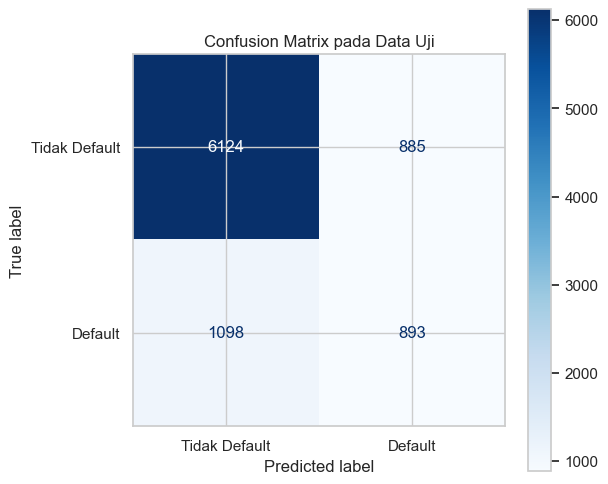


Classification Report:
              precision    recall  f1-score   support

           0     0.8480    0.8737    0.8607      7009
           1     0.5022    0.4485    0.4739      1991

    accuracy                         0.7797      9000
   macro avg     0.6751    0.6611    0.6673      9000
weighted avg     0.7715    0.7797    0.7751      9000



In [33]:
# Prediksi & Evaluasi
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tidak Default','Default'])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix pada Data Uji')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


AUC: 0.6974


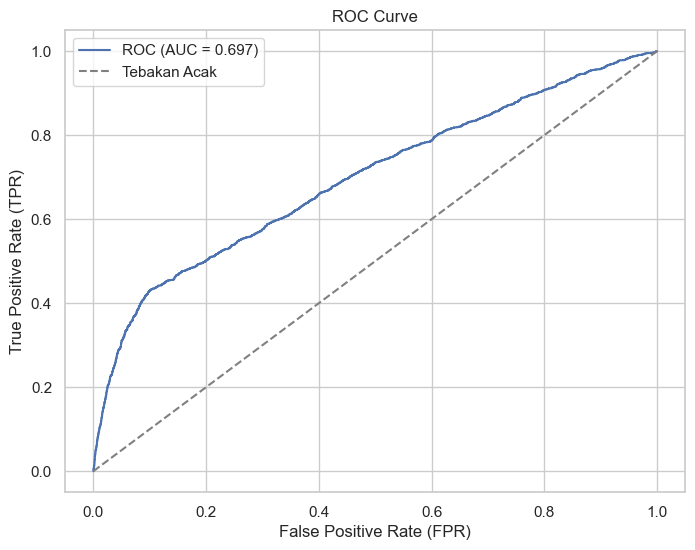

In [34]:
# ROC Curve & AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc_score:.4f}")

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc_score:.3f})')
plt.plot([0,1],[0,1], linestyle='--', color='grey', label='Tebakan Acak')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
import joblib

# Simpan model, scaler, dan urutan fitur ke folder artifacts
joblib.dump(best_model, 'artifacts/logistic_model.joblib')
joblib.dump(scaler, 'artifacts/scaler.joblib')

# Simpan urutan kolom (fitur)
import json
with open('artifacts/feature_list.json', 'w') as f:
    json.dump(X.columns.tolist(), f)

print("✅ Model, scaler, dan feature list berhasil disimpan!")



✅ Model, scaler, dan feature list berhasil disimpan!


In [36]:
# Contoh: ambil baris pertama dari X_test, lakukan prediksi dan tampilkan probabilitas
sample = X_test.iloc[0:1].copy()
# Pastikan sample sudah dalam skala (sudah dilakukan transform di cell10)
proba = best_model.predict_proba(sample)[:,1][0]
pred_label = 'Berisiko Gagal Bayar' if proba >= 0.5 else 'Tidak Berisiko'
print("Probabilitas default:", proba)
print("Label prediksi:", pred_label)

Probabilitas default: 0.33005452967649845
Label prediksi: Tidak Berisiko
